# Scene Recognition with Deep Learning

## Brief
- Due
    - Part 1 Code 09/30/2020 11:59PM (this notebook)
    - Part 2 Code 10/13/2020 11:59PM (to be released later)
    - Report 10/13/2020 11:59PM (to be release later; submission along with Part 2)
- Hand-in: through Gradescope
- Required files: 
    - `<your_gt_username>.zip` against [Project 2 - Part 1 - Code](https://www.gradescope.com/courses/155064/assignments/676907)
        
**Note**:
Working on pairs and individual submissions has to be decided for Project 2 as a whole. For part 1, the grading scheme and total points are the same for indivudual and pair submissions.
    

## Outline
In this project, we will use *convolutional neural nets* to classify images into different scenes.

Basic learning objectives of this project:
1. Construct the fundamental pipeline for performing deep learning using PyTorch;
2. Understand the concepts behind different layers, optimizers.
3. Experiment with different models and observe the performance.

The starter code is mostly initialized to 'placeholder' just so that the starter
code does not crash when run unmodified and you can get a preview of how
results are presented.

## Compute Requirements

This project is doable without a GPU, but a GPU makes the process much more faster and frustration free. Part 1 should be fine to do on a CPU with a little bit of patience.

You can try out Google Colab to run this notebook. These are the steps we follow:
1. Upload this notebook to google colab
2. Zip all the components in the project directory and upload it to the colab runtime
3. Unzip the uploaded zip using ```!unzip -qq <uploaded_file>.zip -d ./```

Remember to download all the files saved and changes to code you made on the colab.

Note that we will not be actively supporting issues with Google colab. Please take help from fellow students and use the internet to solve the issues.

In [2]:
# uncomment for running on colab
#!unzip -qq proj2_colab.zip -d ./

In [3]:
# flag to modify paths to run better on Colab; change it to true if you want to run on colab
use_colab_paths = False 

## Dataset
The dataset is in the ```data``` folder. It has two subfolders: ```train``` and ```test```. Go through any of the folder and find there you will find the folders with scene names like *bedroom*, *forest*, *office*. These are the 15 scenes that we want our model to predict given an RGB image. You can look into folder for each scene to find multiple images. All this data is labelled data provided to you for training and testing your model.

**Let's start coding now!**

## Setup

In [4]:
import os
import torch
import matplotlib.pyplot as plt

from proj2_code.runner import Trainer
from proj2_code.optimizer import get_optimizer
from proj2_code.simple_net import SimpleNet
from proj2_code.image_loader import ImageLoader
from proj2_code.data_transforms import get_fundamental_transforms, get_data_augmentation_transforms
from proj2_code.stats_helper import compute_mean_and_std
from proj2_code.vis import visualize

%load_ext autoreload
%autoreload 2

In [5]:
from proj2_code.proj2_unit_tests.test_base import verify
from proj2_code.proj2_unit_tests.test_stats_helper import test_mean_and_variance
from proj2_code.proj2_unit_tests.test_image_loader import test_dataset_length, test_unique_vals, test_class_values, test_load_img_from_path
from proj2_code.proj2_unit_tests.test_data_transforms import test_fundamental_transforms
from proj2_code.proj2_unit_tests.test_dl_utils import test_predict_labels, test_compute_loss
from proj2_code.proj2_unit_tests.test_simple_net import test_simple_net
from proj2_code.proj2_unit_tests.test_checkpoints import test_simple_net_checkpoint

In [6]:
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available() # will turn off cuda if the machine doesnt have a GPU

In [7]:
data_base_path = '../data/' if not use_colab_paths else 'data/'
model_base_path = '../model_checkpoints/' if not use_colab_paths else 'model_checkpoints/'

In [8]:
print(os.listdir(data_base_path))
print(os.listdir(model_base_path))

# TODO: check that these outputs are as per expectation. It will save a lot of time in debugging issues.

['test', 'train']
['simple_net']


To train a network in PyTorch, we need 4 components:
1. **Dataset** - an object which can load the data and labels given an index.
2. **Model** - an object that contains the network architecture definition.
3. **Loss function** - a function that measures how far the network output is from the ground truth label.
4. **Optimizer** - an object that optimizes the network parameters to reduce the loss value.

## 1 Datasets
One crucial aspect of deep learning is to perform data preprocessing. In DL, we usually *normalize* the dataset and perform some *transformations* on them. The transformations can either help the inputs be compatible with the model (say our model only works on 500x500 images and we need all input to be cropped/scaled to this size) or help in data-augmentation to improve performance (more on this later).


### 1.1 Compute mean and standard deviation of the dataset
In this project we are going to "zero-center" and "normalize" the dataset so that each entry has zero mean and the overall standard deviation is 1. 

**TODO 1**:  fill in the `compute_mean_and_std()` in `stats_helper.py` to compute the **mean** and **standard deviation** of both training and validation data.

Debug tip: If you face an error from StandardScaler about attribute not found, please check that the paths are correct and your code actually finds some images.

In [10]:
print("Testing your mean and std computation: ", verify(test_mean_and_variance))
dataset_mean, dataset_std = compute_mean_and_std(data_base_path)

../proj2_code/proj2_unit_tests/small_data/train
['../proj2_code/proj2_unit_tests/small_data/test/bedroom', '../proj2_code/proj2_unit_tests/small_data/test/coast', '../proj2_code/proj2_unit_tests/small_data/test/forest', '../proj2_code/proj2_unit_tests/small_data/test/highway', '../proj2_code/proj2_unit_tests/small_data/test/industrial', '../proj2_code/proj2_unit_tests/small_data/test/insidecity', '../proj2_code/proj2_unit_tests/small_data/test/kitchen', '../proj2_code/proj2_unit_tests/small_data/test/livingroom', '../proj2_code/proj2_unit_tests/small_data/test/mountain', '../proj2_code/proj2_unit_tests/small_data/test/office', '../proj2_code/proj2_unit_tests/small_data/test/opencountry', '../proj2_code/proj2_unit_tests/small_data/test/store', '../proj2_code/proj2_unit_tests/small_data/test/street', '../proj2_code/proj2_unit_tests/small_data/test/suburb', '../proj2_code/proj2_unit_tests/small_data/test/tallbuilding', '../proj2_code/proj2_unit_tests/small_data/train/bedroom', '../proj2_c

../data/test/bedroom/image_0045.jpg
../data/test/bedroom/image_0046.jpg
../data/test/bedroom/image_0048.jpg
../data/test/bedroom/image_0051.jpg
../data/test/bedroom/image_0055.jpg
../data/test/bedroom/image_0057.jpg
../data/test/bedroom/image_0058.jpg
../data/test/bedroom/image_0061.jpg
../data/test/bedroom/image_0065.jpg
../data/test/bedroom/image_0070.jpg
../data/test/bedroom/image_0072.jpg
../data/test/bedroom/image_0075.jpg
../data/test/bedroom/image_0076.jpg
../data/test/bedroom/image_0078.jpg
../data/test/bedroom/image_0079.jpg
../data/test/bedroom/image_0083.jpg
../data/test/bedroom/image_0085.jpg
../data/test/bedroom/image_0089.jpg
../data/test/bedroom/image_0091.jpg
../data/test/bedroom/image_0094.jpg
../data/test/bedroom/image_0099.jpg
../data/test/bedroom/image_0100.jpg
../data/test/bedroom/image_0101.jpg
../data/test/bedroom/image_0102.jpg
../data/test/bedroom/image_0105.jpg
../data/test/bedroom/image_0106.jpg
../data/test/bedroom/image_0107.jpg
../data/test/bedroom/image_0

../data/test/forest/image_0177.jpg
../data/test/forest/image_0181.jpg
../data/test/forest/image_0182.jpg
../data/test/forest/image_0184.jpg
../data/test/forest/image_0187.jpg
../data/test/forest/image_0189.jpg
../data/test/forest/image_0190.jpg
../data/test/forest/image_0192.jpg
../data/test/forest/image_0193.jpg
../data/test/forest/image_0202.jpg
../data/test/forest/image_0205.jpg
../data/test/forest/image_0214.jpg
../data/test/forest/image_0217.jpg
../data/test/forest/image_0218.jpg
../data/test/forest/image_0227.jpg
../data/test/forest/image_0228.jpg
../data/test/forest/image_0229.jpg
../data/test/forest/image_0233.jpg
../data/test/forest/image_0237.jpg
../data/test/forest/image_0239.jpg
../data/test/forest/image_0240.jpg
../data/test/forest/image_0245.jpg
../data/test/forest/image_0250.jpg
../data/test/forest/image_0254.jpg
../data/test/forest/image_0265.jpg
../data/test/forest/image_0266.jpg
../data/test/forest/image_0267.jpg
../data/test/forest/image_0270.jpg
../data/test/forest/

../data/test/industrial/image_0235.jpg
../data/test/industrial/image_0239.jpg
../data/test/industrial/image_0249.jpg
../data/test/industrial/image_0253.jpg
../data/test/industrial/image_0257.jpg
../data/test/industrial/image_0260.jpg
../data/test/industrial/image_0261.jpg
../data/test/industrial/image_0265.jpg
../data/test/industrial/image_0266.jpg
../data/test/industrial/image_0267.jpg
../data/test/industrial/image_0268.jpg
../data/test/industrial/image_0280.jpg
../data/test/industrial/image_0281.jpg
../data/test/industrial/image_0283.jpg
../data/test/industrial/image_0284.jpg
../data/test/industrial/image_0286.jpg
../data/test/industrial/image_0287.jpg
../data/test/industrial/image_0288.jpg
../data/test/industrial/image_0289.jpg
../data/test/industrial/image_0292.jpg
../data/test/industrial/image_0296.jpg
../data/test/industrial/image_0301.jpg
../data/test/industrial/image_0302.jpg
../data/test/industrial/image_0306.jpg
../data/test/industrial/image_0308.jpg
../data/test/industrial/i

../data/test/kitchen/image_0193.jpg
../data/test/kitchen/image_0196.jpg
../data/test/kitchen/image_0199.jpg
../data/test/kitchen/image_0202.jpg
../data/test/kitchen/image_0205.jpg
../data/test/kitchen/image_0206.jpg
../data/test/kitchen/image_0208.jpg
../data/test/kitchen/image_0210.jpg
../data/test/livingroom/image_0001.jpg
../data/test/livingroom/image_0006.jpg
../data/test/livingroom/image_0009.jpg
../data/test/livingroom/image_0012.jpg
../data/test/livingroom/image_0016.jpg
../data/test/livingroom/image_0017.jpg
../data/test/livingroom/image_0018.jpg
../data/test/livingroom/image_0019.jpg
../data/test/livingroom/image_0026.jpg
../data/test/livingroom/image_0028.jpg
../data/test/livingroom/image_0029.jpg
../data/test/livingroom/image_0030.jpg
../data/test/livingroom/image_0031.jpg
../data/test/livingroom/image_0034.jpg
../data/test/livingroom/image_0035.jpg
../data/test/livingroom/image_0036.jpg
../data/test/livingroom/image_0038.jpg
../data/test/livingroom/image_0044.jpg
../data/te

../data/test/office/image_0028.jpg
../data/test/office/image_0030.jpg
../data/test/office/image_0031.jpg
../data/test/office/image_0033.jpg
../data/test/office/image_0035.jpg
../data/test/office/image_0036.jpg
../data/test/office/image_0039.jpg
../data/test/office/image_0041.jpg
../data/test/office/image_0042.jpg
../data/test/office/image_0045.jpg
../data/test/office/image_0046.jpg
../data/test/office/image_0049.jpg
../data/test/office/image_0051.jpg
../data/test/office/image_0052.jpg
../data/test/office/image_0053.jpg
../data/test/office/image_0054.jpg
../data/test/office/image_0056.jpg
../data/test/office/image_0061.jpg
../data/test/office/image_0066.jpg
../data/test/office/image_0068.jpg
../data/test/office/image_0069.jpg
../data/test/office/image_0070.jpg
../data/test/office/image_0073.jpg
../data/test/office/image_0076.jpg
../data/test/office/image_0078.jpg
../data/test/office/image_0082.jpg
../data/test/office/image_0085.jpg
../data/test/office/image_0086.jpg
../data/test/office/

../data/test/store/image_0101.jpg
../data/test/store/image_0103.jpg
../data/test/store/image_0105.jpg
../data/test/store/image_0108.jpg
../data/test/store/image_0110.jpg
../data/test/store/image_0119.jpg
../data/test/store/image_0120.jpg
../data/test/store/image_0123.jpg
../data/test/store/image_0126.jpg
../data/test/store/image_0128.jpg
../data/test/store/image_0129.jpg
../data/test/store/image_0130.jpg
../data/test/store/image_0131.jpg
../data/test/store/image_0132.jpg
../data/test/store/image_0133.jpg
../data/test/store/image_0137.jpg
../data/test/store/image_0139.jpg
../data/test/store/image_0142.jpg
../data/test/store/image_0144.jpg
../data/test/store/image_0145.jpg
../data/test/store/image_0148.jpg
../data/test/store/image_0154.jpg
../data/test/store/image_0163.jpg
../data/test/store/image_0170.jpg
../data/test/store/image_0172.jpg
../data/test/store/image_0173.jpg
../data/test/store/image_0175.jpg
../data/test/store/image_0177.jpg
../data/test/store/image_0186.jpg
../data/test/s

../data/test/suburb/image_0150.jpg
../data/test/suburb/image_0151.jpg
../data/test/suburb/image_0157.jpg
../data/test/suburb/image_0158.jpg
../data/test/suburb/image_0159.jpg
../data/test/suburb/image_0163.jpg
../data/test/suburb/image_0165.jpg
../data/test/suburb/image_0169.jpg
../data/test/suburb/image_0170.jpg
../data/test/suburb/image_0184.jpg
../data/test/suburb/image_0190.jpg
../data/test/suburb/image_0191.jpg
../data/test/suburb/image_0192.jpg
../data/test/suburb/image_0197.jpg
../data/test/suburb/image_0201.jpg
../data/test/suburb/image_0204.jpg
../data/test/suburb/image_0206.jpg
../data/test/suburb/image_0207.jpg
../data/test/suburb/image_0208.jpg
../data/test/suburb/image_0209.jpg
../data/test/suburb/image_0211.jpg
../data/test/suburb/image_0216.jpg
../data/test/suburb/image_0217.jpg
../data/test/suburb/image_0218.jpg
../data/test/suburb/image_0221.jpg
../data/test/suburb/image_0224.jpg
../data/test/suburb/image_0230.jpg
../data/test/suburb/image_0231.jpg
../data/test/suburb/

../data/train/bedroom/image_0141.jpg
../data/train/bedroom/image_0142.jpg
../data/train/bedroom/image_0144.jpg
../data/train/bedroom/image_0148.jpg
../data/train/bedroom/image_0150.jpg
../data/train/bedroom/image_0152.jpg
../data/train/bedroom/image_0153.jpg
../data/train/bedroom/image_0156.jpg
../data/train/bedroom/image_0157.jpg
../data/train/bedroom/image_0158.jpg
../data/train/bedroom/image_0160.jpg
../data/train/bedroom/image_0161.jpg
../data/train/bedroom/image_0162.jpg
../data/train/bedroom/image_0163.jpg
../data/train/bedroom/image_0166.jpg
../data/train/bedroom/image_0168.jpg
../data/train/bedroom/image_0170.jpg
../data/train/bedroom/image_0175.jpg
../data/train/bedroom/image_0176.jpg
../data/train/bedroom/image_0180.jpg
../data/train/bedroom/image_0182.jpg
../data/train/bedroom/image_0189.jpg
../data/train/bedroom/image_0190.jpg
../data/train/bedroom/image_0191.jpg
../data/train/bedroom/image_0192.jpg
../data/train/bedroom/image_0195.jpg
../data/train/bedroom/image_0196.jpg
.

../data/train/coast/image_0266.jpg
../data/train/coast/image_0268.jpg
../data/train/coast/image_0270.jpg
../data/train/coast/image_0272.jpg
../data/train/coast/image_0277.jpg
../data/train/coast/image_0278.jpg
../data/train/coast/image_0279.jpg
../data/train/coast/image_0280.jpg
../data/train/coast/image_0282.jpg
../data/train/coast/image_0285.jpg
../data/train/coast/image_0288.jpg
../data/train/coast/image_0289.jpg
../data/train/coast/image_0291.jpg
../data/train/coast/image_0292.jpg
../data/train/coast/image_0293.jpg
../data/train/coast/image_0295.jpg
../data/train/coast/image_0296.jpg
../data/train/coast/image_0297.jpg
../data/train/coast/image_0299.jpg
../data/train/coast/image_0300.jpg
../data/train/coast/image_0301.jpg
../data/train/coast/image_0302.jpg
../data/train/coast/image_0303.jpg
../data/train/coast/image_0304.jpg
../data/train/coast/image_0305.jpg
../data/train/coast/image_0306.jpg
../data/train/coast/image_0308.jpg
../data/train/coast/image_0309.jpg
../data/train/coast/

../data/train/forest/image_0241.jpg
../data/train/forest/image_0242.jpg
../data/train/forest/image_0243.jpg
../data/train/forest/image_0244.jpg
../data/train/forest/image_0246.jpg
../data/train/forest/image_0247.jpg
../data/train/forest/image_0248.jpg
../data/train/forest/image_0249.jpg
../data/train/forest/image_0251.jpg
../data/train/forest/image_0252.jpg
../data/train/forest/image_0253.jpg
../data/train/forest/image_0255.jpg
../data/train/forest/image_0256.jpg
../data/train/forest/image_0257.jpg
../data/train/forest/image_0258.jpg
../data/train/forest/image_0259.jpg
../data/train/forest/image_0260.jpg
../data/train/forest/image_0261.jpg
../data/train/forest/image_0262.jpg
../data/train/forest/image_0263.jpg
../data/train/forest/image_0264.jpg
../data/train/forest/image_0268.jpg
../data/train/forest/image_0269.jpg
../data/train/forest/image_0271.jpg
../data/train/forest/image_0273.jpg
../data/train/forest/image_0274.jpg
../data/train/forest/image_0275.jpg
../data/train/forest/image_0

../data/train/industrial/image_0005.jpg
../data/train/industrial/image_0006.jpg
../data/train/industrial/image_0007.jpg
../data/train/industrial/image_0008.jpg
../data/train/industrial/image_0013.jpg
../data/train/industrial/image_0015.jpg
../data/train/industrial/image_0016.jpg
../data/train/industrial/image_0017.jpg
../data/train/industrial/image_0020.jpg
../data/train/industrial/image_0021.jpg
../data/train/industrial/image_0023.jpg
../data/train/industrial/image_0025.jpg
../data/train/industrial/image_0026.jpg
../data/train/industrial/image_0027.jpg
../data/train/industrial/image_0028.jpg
../data/train/industrial/image_0029.jpg
../data/train/industrial/image_0030.jpg
../data/train/industrial/image_0032.jpg
../data/train/industrial/image_0035.jpg
../data/train/industrial/image_0037.jpg
../data/train/industrial/image_0038.jpg
../data/train/industrial/image_0039.jpg
../data/train/industrial/image_0040.jpg
../data/train/industrial/image_0045.jpg
../data/train/industrial/image_0046.jpg


../data/train/industrial/image_0305.jpg
../data/train/industrial/image_0307.jpg
../data/train/industrial/image_0309.jpg
../data/train/industrial/image_0311.jpg
../data/train/insidecity/image_0001.jpg
../data/train/insidecity/image_0002.jpg
../data/train/insidecity/image_0003.jpg
../data/train/insidecity/image_0004.jpg
../data/train/insidecity/image_0006.jpg
../data/train/insidecity/image_0007.jpg
../data/train/insidecity/image_0008.jpg
../data/train/insidecity/image_0010.jpg
../data/train/insidecity/image_0011.jpg
../data/train/insidecity/image_0012.jpg
../data/train/insidecity/image_0013.jpg
../data/train/insidecity/image_0015.jpg
../data/train/insidecity/image_0016.jpg
../data/train/insidecity/image_0017.jpg
../data/train/insidecity/image_0019.jpg
../data/train/insidecity/image_0020.jpg
../data/train/insidecity/image_0021.jpg
../data/train/insidecity/image_0022.jpg
../data/train/insidecity/image_0023.jpg
../data/train/insidecity/image_0024.jpg
../data/train/insidecity/image_0025.jpg


../data/train/insidecity/image_0299.jpg
../data/train/insidecity/image_0300.jpg
../data/train/insidecity/image_0301.jpg
../data/train/insidecity/image_0303.jpg
../data/train/insidecity/image_0304.jpg
../data/train/insidecity/image_0306.jpg
../data/train/insidecity/image_0307.jpg
../data/train/kitchen/image_0002.jpg
../data/train/kitchen/image_0003.jpg
../data/train/kitchen/image_0006.jpg
../data/train/kitchen/image_0008.jpg
../data/train/kitchen/image_0009.jpg
../data/train/kitchen/image_0010.jpg
../data/train/kitchen/image_0012.jpg
../data/train/kitchen/image_0016.jpg
../data/train/kitchen/image_0017.jpg
../data/train/kitchen/image_0018.jpg
../data/train/kitchen/image_0021.jpg
../data/train/kitchen/image_0022.jpg
../data/train/kitchen/image_0023.jpg
../data/train/kitchen/image_0024.jpg
../data/train/kitchen/image_0027.jpg
../data/train/kitchen/image_0028.jpg
../data/train/kitchen/image_0029.jpg
../data/train/kitchen/image_0031.jpg
../data/train/kitchen/image_0033.jpg
../data/train/kit

../data/train/livingroom/image_0145.jpg
../data/train/livingroom/image_0146.jpg
../data/train/livingroom/image_0147.jpg
../data/train/livingroom/image_0148.jpg
../data/train/livingroom/image_0150.jpg
../data/train/livingroom/image_0152.jpg
../data/train/livingroom/image_0153.jpg
../data/train/livingroom/image_0156.jpg
../data/train/livingroom/image_0159.jpg
../data/train/livingroom/image_0160.jpg
../data/train/livingroom/image_0161.jpg
../data/train/livingroom/image_0163.jpg
../data/train/livingroom/image_0166.jpg
../data/train/livingroom/image_0167.jpg
../data/train/livingroom/image_0169.jpg
../data/train/livingroom/image_0171.jpg
../data/train/livingroom/image_0173.jpg
../data/train/livingroom/image_0174.jpg
../data/train/livingroom/image_0175.jpg
../data/train/livingroom/image_0176.jpg
../data/train/livingroom/image_0177.jpg
../data/train/livingroom/image_0179.jpg
../data/train/livingroom/image_0180.jpg
../data/train/livingroom/image_0181.jpg
../data/train/livingroom/image_0182.jpg


../data/train/mountain/image_0154.jpg
../data/train/mountain/image_0155.jpg
../data/train/mountain/image_0156.jpg
../data/train/mountain/image_0157.jpg
../data/train/mountain/image_0158.jpg
../data/train/mountain/image_0159.jpg
../data/train/mountain/image_0161.jpg
../data/train/mountain/image_0162.jpg
../data/train/mountain/image_0163.jpg
../data/train/mountain/image_0165.jpg
../data/train/mountain/image_0166.jpg
../data/train/mountain/image_0168.jpg
../data/train/mountain/image_0170.jpg
../data/train/mountain/image_0171.jpg
../data/train/mountain/image_0172.jpg
../data/train/mountain/image_0174.jpg
../data/train/mountain/image_0175.jpg
../data/train/mountain/image_0176.jpg
../data/train/mountain/image_0177.jpg
../data/train/mountain/image_0182.jpg
../data/train/mountain/image_0183.jpg
../data/train/mountain/image_0186.jpg
../data/train/mountain/image_0187.jpg
../data/train/mountain/image_0188.jpg
../data/train/mountain/image_0189.jpg
../data/train/mountain/image_0190.jpg
../data/trai

../data/train/office/image_0117.jpg
../data/train/office/image_0118.jpg
../data/train/office/image_0119.jpg
../data/train/office/image_0120.jpg
../data/train/office/image_0121.jpg
../data/train/office/image_0123.jpg
../data/train/office/image_0124.jpg
../data/train/office/image_0126.jpg
../data/train/office/image_0127.jpg
../data/train/office/image_0130.jpg
../data/train/office/image_0131.jpg
../data/train/office/image_0134.jpg
../data/train/office/image_0135.jpg
../data/train/office/image_0138.jpg
../data/train/office/image_0140.jpg
../data/train/office/image_0142.jpg
../data/train/office/image_0143.jpg
../data/train/office/image_0144.jpg
../data/train/office/image_0146.jpg
../data/train/office/image_0147.jpg
../data/train/office/image_0148.jpg
../data/train/office/image_0150.jpg
../data/train/office/image_0155.jpg
../data/train/office/image_0157.jpg
../data/train/office/image_0158.jpg
../data/train/office/image_0159.jpg
../data/train/office/image_0164.jpg
../data/train/office/image_0

../data/train/opencountry/image_0204.jpg
../data/train/opencountry/image_0206.jpg
../data/train/opencountry/image_0208.jpg
../data/train/opencountry/image_0210.jpg
../data/train/opencountry/image_0211.jpg
../data/train/opencountry/image_0212.jpg
../data/train/opencountry/image_0215.jpg
../data/train/opencountry/image_0216.jpg
../data/train/opencountry/image_0218.jpg
../data/train/opencountry/image_0219.jpg
../data/train/opencountry/image_0220.jpg
../data/train/opencountry/image_0221.jpg
../data/train/opencountry/image_0222.jpg
../data/train/opencountry/image_0224.jpg
../data/train/opencountry/image_0225.jpg
../data/train/opencountry/image_0227.jpg
../data/train/opencountry/image_0228.jpg
../data/train/opencountry/image_0230.jpg
../data/train/opencountry/image_0231.jpg
../data/train/opencountry/image_0233.jpg
../data/train/opencountry/image_0234.jpg
../data/train/opencountry/image_0237.jpg
../data/train/opencountry/image_0238.jpg
../data/train/opencountry/image_0239.jpg
../data/train/op

../data/train/store/image_0078.jpg
../data/train/store/image_0079.jpg
../data/train/store/image_0080.jpg
../data/train/store/image_0081.jpg
../data/train/store/image_0082.jpg
../data/train/store/image_0083.jpg
../data/train/store/image_0084.jpg
../data/train/store/image_0085.jpg
../data/train/store/image_0086.jpg
../data/train/store/image_0087.jpg
../data/train/store/image_0088.jpg
../data/train/store/image_0089.jpg
../data/train/store/image_0090.jpg
../data/train/store/image_0091.jpg
../data/train/store/image_0096.jpg
../data/train/store/image_0099.jpg
../data/train/store/image_0102.jpg
../data/train/store/image_0104.jpg
../data/train/store/image_0106.jpg
../data/train/store/image_0107.jpg
../data/train/store/image_0109.jpg
../data/train/store/image_0111.jpg
../data/train/store/image_0112.jpg
../data/train/store/image_0113.jpg
../data/train/store/image_0114.jpg
../data/train/store/image_0115.jpg
../data/train/store/image_0116.jpg
../data/train/store/image_0117.jpg
../data/train/store/

../data/train/street/image_0113.jpg
../data/train/street/image_0118.jpg
../data/train/street/image_0119.jpg
../data/train/street/image_0121.jpg
../data/train/street/image_0122.jpg
../data/train/street/image_0124.jpg
../data/train/street/image_0125.jpg
../data/train/street/image_0126.jpg
../data/train/street/image_0127.jpg
../data/train/street/image_0128.jpg
../data/train/street/image_0129.jpg
../data/train/street/image_0131.jpg
../data/train/street/image_0132.jpg
../data/train/street/image_0133.jpg
../data/train/street/image_0134.jpg
../data/train/street/image_0135.jpg
../data/train/street/image_0136.jpg
../data/train/street/image_0137.jpg
../data/train/street/image_0138.jpg
../data/train/street/image_0140.jpg
../data/train/street/image_0141.jpg
../data/train/street/image_0142.jpg
../data/train/street/image_0143.jpg
../data/train/street/image_0144.jpg
../data/train/street/image_0145.jpg
../data/train/street/image_0146.jpg
../data/train/street/image_0147.jpg
../data/train/street/image_0

../data/train/suburb/image_0186.jpg
../data/train/suburb/image_0187.jpg
../data/train/suburb/image_0188.jpg
../data/train/suburb/image_0189.jpg
../data/train/suburb/image_0193.jpg
../data/train/suburb/image_0194.jpg
../data/train/suburb/image_0195.jpg
../data/train/suburb/image_0196.jpg
../data/train/suburb/image_0198.jpg
../data/train/suburb/image_0199.jpg
../data/train/suburb/image_0200.jpg
../data/train/suburb/image_0202.jpg
../data/train/suburb/image_0203.jpg
../data/train/suburb/image_0205.jpg
../data/train/suburb/image_0210.jpg
../data/train/suburb/image_0212.jpg
../data/train/suburb/image_0213.jpg
../data/train/suburb/image_0214.jpg
../data/train/suburb/image_0215.jpg
../data/train/suburb/image_0219.jpg
../data/train/suburb/image_0220.jpg
../data/train/suburb/image_0222.jpg
../data/train/suburb/image_0223.jpg
../data/train/suburb/image_0225.jpg
../data/train/suburb/image_0226.jpg
../data/train/suburb/image_0227.jpg
../data/train/suburb/image_0228.jpg
../data/train/suburb/image_0

../data/train/tallbuilding/image_0223.jpg
../data/train/tallbuilding/image_0225.jpg
../data/train/tallbuilding/image_0226.jpg
../data/train/tallbuilding/image_0228.jpg
../data/train/tallbuilding/image_0229.jpg
../data/train/tallbuilding/image_0230.jpg
../data/train/tallbuilding/image_0232.jpg
../data/train/tallbuilding/image_0235.jpg
../data/train/tallbuilding/image_0236.jpg
../data/train/tallbuilding/image_0237.jpg
../data/train/tallbuilding/image_0238.jpg
../data/train/tallbuilding/image_0239.jpg
../data/train/tallbuilding/image_0241.jpg
../data/train/tallbuilding/image_0242.jpg
../data/train/tallbuilding/image_0245.jpg
../data/train/tallbuilding/image_0246.jpg
../data/train/tallbuilding/image_0248.jpg
../data/train/tallbuilding/image_0249.jpg
../data/train/tallbuilding/image_0250.jpg
../data/train/tallbuilding/image_0252.jpg
../data/train/tallbuilding/image_0253.jpg
../data/train/tallbuilding/image_0254.jpg
../data/train/tallbuilding/image_0255.jpg
../data/train/tallbuilding/image_0

In [12]:
print('Dataset mean = {}, standard deviation = {}'.format(dataset_mean, dataset_std))

Dataset mean = [0.45547487], standard deviation = [0.25316328]


### 1.2 ImageLoader

Now let's create the **Datasets** object to be used later. Remember back in Project 1, we have initialized such a class to load 5 images? Here the task is similar: we have to load each image as well as it's classification label. The essence is to retrieve the paths to all the images required, and be able to provide the **path** and the **class id** when given an index.

We will map the scene names (text) into indices 0 to 14 in the image loader. You can choose any mapping you want but once fixed, it has to be consistent throughout this notebook.

**TODO 2:** complete the `image_loader.py`

In [16]:
inp_size = (64,64)
print("Testing your image loader (length):", verify(test_dataset_length))
print("Testing your image loader (values):", verify(test_unique_vals))
print("Testing your image loader (classes):", verify(test_class_values))
print("Testing your image loader (paths):", verify(test_load_img_from_path))

Testing your image loader (length): "Correct"
Testing your image loader (values): "Correct"
Testing your image loader (classes): "Correct"
Testing your image loader (paths): "Correct"


### 1.3 Data transforms
In this section, we will construct some fundamental transforms to process RGB images into torch tensors, which we can provide as input to our model.

1. Resize the input image to the desired shape;
2. Convert it to a tensor;
3. Normalize them based on the computed mean and standard deviation.

**TODO 3:** For this part, complete the function `get_fundamental_transforms()` in `data_transforms.py` 

In [17]:
print("Testing your fundamental data transforms: ", verify(test_fundamental_transforms))

Testing your fundamental data transforms:  "Correct"


## 2 Model Architecture and Forward Pass

### 2.1 SimpleNet Model

The data is ready! Now we are preparing to move to the actual core of deep learning: the architecture. To get you started in this part, simply define a **2-layer** model in the `simple_net.py`. Here by "2 layers" we mean **2 convolutional layers**, so you need to figure out the supporting utilities like ReLU, Max Pooling, and Fully Connected layers, and configure them with proper parameters to make the tensor flow.

You may refer the image *simplenet.jpg* in the base folder for a sample network architecture (it's the architecture TAs used in their implementation and is sufficient to get you pass Part 1).

**TODO 4**: Do the following in ```simple_net.py```:
- Initialize ```self.cnn_layers```
- Initialize ```self.fc_layers```
- Write the forward function

Leave the ```self.loss_criterion = None``` for now.

In [18]:
print("Testing your SimpleNet architecture: ", verify(test_simple_net))

2
2
2
Testing your SimpleNet architecture:  "Correct"


### 2.2 Output prediction

Let's see what out model's forward function produces for a sample input, and how it relates to classification. Pytorch's convolution and FC layers are initialized with random weights. So we should not expect any useful output without any training.

We will use a data-point from the dataloader we have already created and run the model on it.

In [87]:
simple_model = SimpleNet()
dataset_mean = 0.45547487
dataset_std = 0.25316328
image_loader = ImageLoader(data_base_path, 
                           split='train', 
                           transform=get_fundamental_transforms(inp_size, dataset_mean, dataset_std)
                          )

In [75]:
# get the 0th sample
sample_image, sample_label = next(iter(image_loader))

In [76]:
print('Input image shape = ', sample_image.shape)

Input image shape =  torch.Size([1, 64, 64])


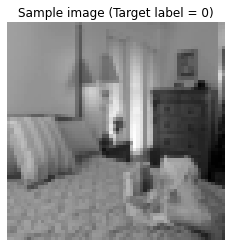

In [77]:
#show the image
fig, axs = plt.subplots()
axs.imshow(sample_image.squeeze().numpy(), cmap='gray')
axs.axis('off')
axs.set_title('Sample image (Target label = {})'.format(sample_label))
plt.show()

In [104]:
# run the image through the model
sample_model_output = simple_model(sample_image.unsqueeze(0)).detach()

torch.Size([1, 15])
tensor([[-0.0118,  0.1551, -0.0613, -0.0544,  0.1449,  0.0933,  0.1924,  0.0129,
          0.1531,  0.0384, -0.1348, -0.0626, -0.1207, -0.1493, -0.0044]],
       grad_fn=<AddmmBackward>)


In [98]:
print(sample_model_output)

tensor([[-0.0036,  0.0490,  0.2458, -0.2462, -0.0403,  0.0021, -0.1839, -0.0049,
         -0.1609,  0.0156, -0.0209, -0.0176, -0.0776, -0.1704,  0.0237]])


We have a 15-dimensional tensor as output, but how does it relate to classification?

We first convert the this tensor into a probability distribution over 15 classes by applying the [Softmax](https://en.wikipedia.org/wiki/Softmax_function) operation.

In [99]:
sample_probability_values = torch.nn.functional.softmax(sample_model_output, dim=1)

In [100]:
print(sample_probability_values)

tensor([[0.0686, 0.0723, 0.0881, 0.0538, 0.0662, 0.0690, 0.0573, 0.0685, 0.0586,
         0.0700, 0.0675, 0.0677, 0.0637, 0.0581, 0.0705]])


The prediction of the model will be the index where the probability distribution is the maximum. Convince yourself that the argmax-operation on *sample_model_values* is the same as the argmax-operation on *sample_probability_values*.

**TODO 5:** Complete the ```predict_labels()``` function in ```dl_utils.py```.

## 3 Loss function

We have written a model which takes in a tensor for an image and produces a 15 dimensional output for it. We saw in the previous section on how the output relates to the prediction and probability distribution. But how do we quantify the performance of the model, and how do we use that quantification to form an objective function which we can minimize.

Ideally, we would want the probability function to have value 1 for the target *sample_label* and value 0 for the remaining class indices. To penalize the deviation between the desired probability distribution and the model-predicted distrtibution, we use the KL-divergence loss or the cross-entropy loss. Please refer to [this stackexchange post](https://datascience.stackexchange.com/questions/20296/cross-entropy-loss-explanation) for a good explanation and derivation.

**TODO 6:** Assign a loss function to ```self.loss_criterion``` in ```simple_net.py```. Note that we have not done a softmax operation in the model's forward function and choose the [appropriate loss function](https://pytorch.org/docs/stable/nn.html#loss-functions).

**TODO 7:** Complete the ```compute_loss()``` function in ```dl_utils.py``` to use the model's loss criterion and compute the loss

In [114]:
simple_model = SimpleNet()

In [115]:
print(simple_model)

SimpleNet(
  (cnn_layers): Sequential(
    (conv_1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (maxpool_1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (relu_1): ReLU()
    (conv_2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (maxpool_2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (relu_2): ReLU()
  )
  (fc_layers): Sequential(
    (Flatten): Flatten()
    (fc1): Linear(in_features=500, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=15, bias=True)
  )
  (loss_criterion): KLDivLoss()
)


In [143]:
print("Testing your model prediction: ", verify(test_predict_labels))
print("Testing your loss values: ", verify(test_compute_loss))

Testing your model prediction:  "Correct"
Testing your loss values:  "Correct"


## 4 Optimizer

### 4.1 Manual gradient descent using Pytorch's autograd

Till now, we have defined the model, and designed a loss function which is a proxy for *good* classification. We now to optimize the weights of the network so that the loss function is minimized.

Pytorch is a very useful library for deep learning because a lot of tensor operations and functions support the flow of gradients. This feature is called [autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html). This functionality lets use use gradient based optimization techniques like gradient descent without writing a lot of code.

Let us first understand how we can access the gradients.

### Define a model and a loss function
Suppose we have a simple objective function that looks like:
$$ L(w) =  w^2 - 10w + 25 $$

This is a convex problem, and we know that the loss $L$ is minimized for $w=5$, and we can obtain this in closed form.

But let us use gradient descent to obtain the solution in this case.

In [144]:
import torch
from torch import tensor

def quadratic_loss(w: tensor) -> tensor:
    assert w.shape==(1,)

    # loss function
    L = torch.pow(w, 2) - 10 * w + 25
    
    return L

Let's compute the loss at w = 0.

In [145]:
w = tensor([0.0], requires_grad=True)

loss = quadratic_loss(w)

print('w={:.4f}\tLoss={:.4f}'.format(w.detach().numpy().item(), loss.detach().numpy().item()))

w=0.0000	Loss=25.0000


Now we can do a backward pass of the gradients to get the gradient of loss w.r.t w. Now we need to calculate the gradients with regard to the weights and biases using backprop. It will be very painful if we do it manually, but thankfully, in PyTorch we can have everything covered with autograd, which only needs a simple call of **.backward()** on our loss.

In [146]:
# perform backward on loss (we need to retain graph here otherwise Pytorch will throw it away)
loss.backward(retain_graph=True)

print(w.grad.data)

# manually zero out the gradient
w.grad.zero_()
pass

tensor([-10.])


Does this gradient match with the one you compute manually?

With the gradients, we can update the weights and biases using gradient descent:
$$w_{k+1}=w_{k} - \alpha\frac{\partial L}{\partial w_k}$$
where $w$ is the parameter we are updating, $\alpha$ is the learning rate, and $\frac{\partial L}{\partial w_k}$ is the gradient at step $k$. You can learn more about gradient descent [here](https://en.wikipedia.org/wiki/Gradient_descent) and [here](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent)

In [147]:
# set learning rate
lr = .03

def gradientDescentStep(w: tensor, L: tensor, lr: float=1e-3) -> None:
    '''
    Take a step of the gradient descent
    '''
    
    # manually zero out the gradient
    w.grad.zero_()

    # perform backward on loss (we need to retain graph here otherwise Pytorch will throw it away)
    L.backward(retain_graph=True)
    
    with torch.no_grad():
        w -= lr * w.grad

Let's take one step of the gradient descent and check if the the loss value decreased

In [148]:
loss = quadratic_loss(w)

gradientDescentStep(w, loss, lr) 

In [149]:
loss = quadratic_loss(w)
print('w={:.4f}\tLoss={:.4f}'.format(w.detach().numpy().item(), loss.detach().numpy().item()))

w=0.3000	Loss=22.0900


Looks like it's been optimized!

Now let's run a few more updates and see where we can get!

In [150]:
import time


start = time.time()
for i in range(200):
    loss = quadratic_loss(w)
    if not (i+1)%10:
        print('Iteration {}: w={:.4f}\tLoss={:.4f}'.format(
            i+1, w.detach().numpy().item(), loss.detach().numpy().item()))
        
    gradientDescentStep(w, loss, lr) 
        
print('\noptimization takes %0.3f seconds'%(time.time()-start))

Iteration 10: w=2.3069	Loss=7.2527
Iteration 20: w=3.5495	Loss=2.1040
Iteration 30: w=4.2187	Loss=0.6104
Iteration 40: w=4.5792	Loss=0.1771
Iteration 50: w=4.7733	Loss=0.0514
Iteration 60: w=4.8779	Loss=0.0149
Iteration 70: w=4.9342	Loss=0.0043
Iteration 80: w=4.9646	Loss=0.0013
Iteration 90: w=4.9809	Loss=0.0004
Iteration 100: w=4.9897	Loss=0.0001
Iteration 110: w=4.9945	Loss=0.0000
Iteration 120: w=4.9970	Loss=0.0000
Iteration 130: w=4.9984	Loss=0.0000
Iteration 140: w=4.9991	Loss=0.0000
Iteration 150: w=4.9995	Loss=0.0000
Iteration 160: w=4.9997	Loss=0.0000
Iteration 170: w=4.9999	Loss=0.0000
Iteration 180: w=4.9999	Loss=0.0000
Iteration 190: w=5.0000	Loss=-0.0000
Iteration 200: w=5.0000	Loss=0.0000

optimization takes 0.070 seconds


Seems that it's doing a great job training our model! The loss now has decreased significantly to a pretty small value.

### 4.2 Optimization using Pytorch's gradient descent optimizer

Now let's see how we can simplify this using the `torch.optim` package from PyTorch. You can see that using optimizer from `torch.optim` package can achieve the same results with a lot less code from our side. Also, there are many features available over the vanilla gradient descent. Let's use the Stochastic Gradient Descent (SGD) optimizer available in Pytorch.

In [134]:
from torch.optim import SGD

# define parameters we want to optimize
w = tensor([0.0], requires_grad=True)

optimizer = SGD([w], lr=lr)
print(lr)
start = time.time()
for i in range(200):
    loss = quadratic_loss(w)   
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if not (i+1)%10:
        print('Iteration {}: w={:.4f}\tLoss={:.4f}'.format(
            i+1, w.detach().numpy().item(), loss.detach().numpy().item()))
        
print('\noptimization takes %0.3f seconds'%(time.time()-start))

0.03
Iteration 10: w=2.3069	Loss=8.2081
Iteration 20: w=3.5495	Loss=2.3812
Iteration 30: w=4.2187	Loss=0.6908
Iteration 40: w=4.5792	Loss=0.2004
Iteration 50: w=4.7733	Loss=0.0581
Iteration 60: w=4.8779	Loss=0.0169
Iteration 70: w=4.9342	Loss=0.0049
Iteration 80: w=4.9646	Loss=0.0014
Iteration 90: w=4.9809	Loss=0.0004
Iteration 100: w=4.9897	Loss=0.0001
Iteration 110: w=4.9945	Loss=0.0000
Iteration 120: w=4.9970	Loss=0.0000
Iteration 130: w=4.9984	Loss=0.0000
Iteration 140: w=4.9991	Loss=0.0000
Iteration 150: w=4.9995	Loss=0.0000
Iteration 160: w=4.9997	Loss=0.0000
Iteration 170: w=4.9999	Loss=0.0000
Iteration 180: w=4.9999	Loss=0.0000
Iteration 190: w=5.0000	Loss=0.0000
Iteration 200: w=5.0000	Loss=0.0000

optimization takes 0.079 seconds


### 4.3 Setting up the optimizer for SimpleNet

**TODO 8:** **initialize the following cell with proper values for learning rate and weight decay** 

**Note:** There is nothing to do in this TODO for the first pass. You'll train the model with these values and it will be bad. Then you can come back here and tune the parameters.

In [154]:
# TODO: add a decent initial setting and tune from there. These values are intentionally bad.
optimizer_config = {
  "optimizer_type": "sgd",
  "lr": 1e-5,
  "weight_decay": 1e-2
}

We will now set up a utility function to define an optimizer on the loss for a model.

**TODO 9:** complete the ```get_optimizer()``` function in ```optimizer.py```. The helper function accepts three basic configurations as defined below. Any other configuration is optional. *SGD* optimizer type should be supported, anything else is optional.

In [156]:
optimizer = get_optimizer(simple_model, optimizer_config)

{'optimizer_type': 'sgd', 'lr': 1e-05, 'weight_decay': 0.01}
sgd
1e-05
0.01


## 5 Training SimpleNet

We have completed all the components required to train the first model for this course. Let's pass in the model architecture, optimizer, transforms for both the training and testing datasets into the trainer, and proceed to the next cell to train it. If you have implemented everything correctly, you should be seeing a decreasing loss value.

**Note** in this project, we will be using the test set as the validation set (i.e. using it to guide our decisions about models and hyperparamters while training. In actual practise, you would not interact with the test set until reporting the final results.

**Note** that your CPU should be sufficient to handle the training process for all networks in this project, and the following training cells will take less than 5 minutes; you may also want to decrease the value for `num_epochs` and quickly experiment with your parameters. The default value of **30** is good enough to get you around the threshold for Part 1, and you are free to increase it a bit and adjust other parameters in this part.

In [157]:
# re-init the model so that the weights are all random
simple_model = SimpleNet()
optimizer = get_optimizer(simple_model, optimizer_config)

trainer = Trainer(data_dir=data_base_path, 
                  model = simple_model,
                  optimizer = optimizer,
                  model_dir = os.path.join(model_base_path, 'simple_net'),
                  train_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  test_data_transforms = get_fundamental_transforms(inp_size, dataset_mean, dataset_std),
                  batch_size = 32,
                  load_from_disk = False,
                  cuda = is_cuda
                 )

{'optimizer_type': 'sgd', 'lr': 1e-05, 'weight_decay': 0.01}
sgd
1e-05
0.01


In [160]:
trainer.train(num_epochs=30)

torch.Size([32, 15])
tensor([[ 1.9581e-02,  3.6688e-02,  1.5078e-01,  3.8827e-05,  1.7170e-01,
          1.7153e-01,  1.1817e-01, -6.5663e-02,  1.0613e-01, -7.3486e-02,
          6.9614e-02,  1.0182e-01, -3.3025e-02,  3.5099e-02, -1.5054e-01],
        [ 1.5928e-02, -2.5340e-02,  1.8142e-01, -7.6985e-02,  1.7503e-01,
          1.9319e-01,  8.3650e-02, -1.7454e-01,  1.2245e-01, -1.4991e-01,
          7.8194e-02,  1.0667e-01,  2.1127e-02,  2.6750e-02, -1.2018e-01],
        [ 2.2497e-02, -6.4926e-02,  1.8318e-01, -5.7555e-02,  1.8445e-01,
          1.3329e-01,  2.4781e-02, -9.0627e-02,  7.7663e-02, -8.9471e-02,
          7.0173e-02,  1.1009e-01, -4.7221e-02,  6.3057e-02, -1.0676e-01],
        [ 1.9649e-02, -7.5693e-02,  1.5753e-01, -3.7790e-02,  6.8996e-02,
          1.2303e-01,  5.4911e-02, -1.0040e-01,  7.9731e-02, -5.4108e-02,
          1.9873e-02,  9.4096e-02, -6.7336e-02,  3.1955e-02, -1.0282e-01],
        [-8.9617e-03, -4.6540e-02,  1.2686e-01, -4.7198e-02,  1.5631e-01,
          1.2

RuntimeError: log_vml_cpu not implemented for 'Long'

Now let's have your model predict on some examples and see how well it performs qualitatively. You should try the following cell multiple times to understand whats happening.

Examples from train split:
torch.Size([1, 15])
tensor([[ 0.0147, -0.0659,  0.1634, -0.0315,  0.0983,  0.1362,  0.0970, -0.1363,
          0.0915, -0.0794,  0.0289,  0.1091, -0.0761,  0.0665, -0.0974]])
torch.Size([1, 15])
tensor([[ 0.0424, -0.0323,  0.1824, -0.0413,  0.1917,  0.1690,  0.0034, -0.1048,
          0.0985, -0.0615,  0.0737,  0.1389, -0.0549,  0.0517, -0.1152]])
torch.Size([1, 15])
tensor([[ 0.0244, -0.0452,  0.1646, -0.0558,  0.1088,  0.1361,  0.0308, -0.1258,
          0.1069, -0.0716,  0.0313,  0.0973, -0.0492,  0.0535, -0.1162]])
torch.Size([1, 15])
tensor([[ 0.0599, -0.0648,  0.2006, -0.0330,  0.1145,  0.1446,  0.0448, -0.1370,
          0.0961, -0.0224,  0.0322,  0.0580, -0.0994,  0.0382, -0.1192]])


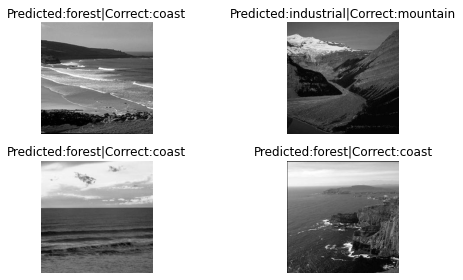

In [159]:
# visualize train split
print("Examples from train split:")
visualize(simple_model, 'train', get_fundamental_transforms(inp_size, dataset_mean, dataset_std), data_base_path)

In [ ]:
# visualize test split
print("Examples from test split:")
visualize(simple_model, 'test', get_fundamental_transforms(inp_size, dataset_mean, dataset_std), data_base_path)

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print('Train Accuracy = {:.4f}; Validation Accuracy = {:.4f}'.format(train_accuracy, validation_accuracy))

In [ ]:
print('Testing simple net weights saved: ', verify(test_simple_net_checkpoint))

After you have finished the training process, now plot out the loss and accuracy history. You can also check out the final accuracy for both training and validation data. Copy the accuracy plots and values onto the report, and answer the questions there. 

**TODO 10:** Obtain a **45%** validation accuracy to receive full credits for Part 1. You can go back to TODO 8 first to tune your paramters for optimization using the following tips:

**Tips**:
1. If the loss decreases very slowly, try increasing the value of the lr (learning rate).
2. Initially keep the value of weight decay (L2-regulization) very low.
3. Try to first adjust lr in multiples of 3 initially. When you are close to reasonable performance, do a more granular adjustment.
4. If you want to increase the validation accuracy by a little bit, try increasing the weight_decay to prevent overfitting. Do not use tricks from Section 6 just yet.

If you still need to tweak the model architecture, you are free to do so. But remember complex models will require more time to train, and TAs could achieve ~50% accuracy with the described model.

## Code testing
We have provided a set of tests for you to evaluate your implementation. We have included tests inside ```proj2.ipynb``` so you can check your progress as you implement each section. At the end, you should call the tests from the terminal using the command ```pytest proj2_code/proj2_unit_tests/```

## Submission

This is very important as you will lose 5 points for every time you do not follow the instructions.

Do install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that's not in there by default will probably cause your code to break during grading. Do use absolute paths in your code or your code will break. Use relative paths like the starter code already does. Failure to follow any of these instructions will lead to point deductions. Create the zip file using ```python zip_submission.py --gt_username <your_gt_username>``` (it will zip up the appropriate directories/files for you!) and hand it through Gradescope. Remember to submit your report as a PDF to Gradescope as well.

## Rubric
| Test name | Scores |
| --------- | ------ |
| ```test_mean_and_variance``` | 3 |
| ```test_fundamental_transforms``` | 3 |
| ```test_dataset_length``` | 2 |
| ```test_class_values``` | 3 | 
| ```test_unique_values``` | 3 |
| ```test_load_img_from_path``` | 3 |
| ```test_predict_labels``` | 4 |
| ```test_compute_loss``` | 4 |
| ```test_simple_net``` | 8 |
| ```test_simple_net_checkpoint``` | 2 |

## Credit

Assignment developed by Ayush Baid, Haoxin Ma, Jing Wu and Frank Dellaert, based on a the original assigment by Ayush Baid, Cusuh Ham, Jonathan Balloch, Shenhao Jiang, Frank Dellaert, and James Hays.